# First example

The following example shows the steps to develop a preventive maintenance policy
by age on circuit breakers:

1. Perform a survival analysis on lifetime data,
2. Compute the optimal age of replacement,
3. Compute the expected total discounting costs and number of expected
   replacements for the next years.

## Survival analysis

The survival analysis is perfomed by computing the Kaplan-Meier estimator and fitting the
parameters of a Weibull and a Gompertz distribution with the maximum likelihood
estimator.

In [1]:
import pandas as pd
from relife2.utils.dataset import load_circuit_breaker

time, event, entry = load_circuit_breaker()
data = pd.DataFrame({"time": time, "event": event, "entry": entry})
display(data.head(n=15))

,time,event,entry
0,34.0,1.0,33.0
1,28.0,1.0,27.0
2,12.0,1.0,11.0
3,38.0,1.0,37.0
4,18.0,1.0,17.0
5,32.0,1.0,31.0
6,44.0,1.0,43.0
7,49.0,1.0,48.0
8,27.0,1.0,26.0
9,47.0,1.0,46.0


In [2]:
from relife2 import KaplanMeier, Weibull, Gompertz

km = KaplanMeier().fit(time, event, entry)
weibull = Weibull().fit(time, event, entry)
gompertz = Gompertz().fit(time, event, entry)

Here are the estimated parameters after fitting the models (note that ``km`` does note have parameters as it is a non-parametric estimator)

In [3]:
print("Weibull parameters (shape, rate) :", weibull.params)
print("Gompertz parameters (shape, rate) :", gompertz.params)

Weibull parameters (shape, rate) : [3.7267452  0.01232326]
Gompertz parameters (shape, rate) : [0.00390781 0.07579546]


The results of fitting the Weibull and Gompertz distributions are compared by looking at their AIC. Those values are stored in the ``fitting_results`` instance created and saved inside your model instance after the fit.

In [4]:
print("Weibull AIC :", weibull.fitting_results.AIC)
print("Gompertz AIC :", gompertz.fitting_results.AIC)

Weibull AIC : 2493.721978543718
Gompertz AIC : 2485.567310362761


The Gompertz distribution gives the best fit and will be chosen for the next step of the study. The code below plots the survival function obtained by the Kaplan-Meier estimator and the maximum likelihood estimator for the Weibull and Gompertz distributions.

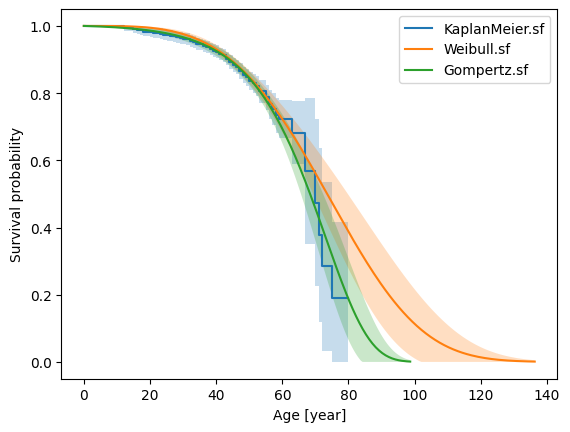

In [5]:
import matplotlib.pyplot as plt

km.plot.sf()
weibull.plot.sf()
gompertz.plot.sf()
plt.xlabel("Age [year]")
plt.ylabel("Survival probability")
plt.show()

## Optimal age replacement

We consider 3 circuit breakers with the following parameters:

- the current ages of the circuit breakers are 15, 20, and 25 years respectively
- the preventive costs of replacement are evaluated 10 k€
- the failure costs (e.g. lost energy) are evaluated 900, 500 and 100 k€ respectively
- the discount rate is 0.04

<div class="alert alert-info">
When you want to pass different parameters for each asset, you generally encode them in a 2D array. The first axis corresponds to each assets and the second axis corresponds to the values.
</div>

Current ages are stored in ``a0``, preventive costs of replacement in ``cp``, failure costs in ``cf``. As there are three assets, we must reshape each array in 2D when necessary. 

In [6]:
import numpy as np

cp = 10  # BE CAREFULL ARRAY MUST HAVE THE SAME SHAPE
# shape is (3, 1) meaning 3 assets and 1 parameter value per asset
a0 = np.array([15, 20, 25]).reshape(-1, 1)
cf = np.array([900, 500, 100]).reshape(-1, 1)

discount_rate = 0.04

Then, you can instanciate an ``AgeReplacementPolicy`` object as follow :

In [7]:
from relife2 import AgeReplacementPolicy

policy = AgeReplacementPolicy(gompertz, cf, cp, discount_rate=discount_rate, a0=a0)

This policy object as an attribute called ``ar`` corresponding to the ages of preventive replacement. That's the parameter we want to optimize. For now, it is set to ``None``. After fitting the policy, its value will be set to the optimal age given the costs and survival behaviour of the assets

In [8]:
print(policy.ar)

None


Actually, ``AgeReplacementPolicy`` has an extra attribute called ``ar1`` corresponding to the ages of the first replacements. In this case, they won't correspond to ``ar`` because assets were not new, their current ages were set to ``a0``. Thus, `ar1` are the time left until the first replacement, whereas `ar` is the optimal age of replacement for the next replacements. For more details about the difference between ``ar1`` and ``ar`` see ... . Otherwise, ``ar1`` is ``None``.

In [9]:
policy.fit(inplace=True)
ar1 = policy.ar1
ar = policy.ar

print("optimal ar1", ar1.squeeze())
print("\noptimal ar", ar.squeeze())

optimal ar1 [ 7.83000887  9.07149393 19.03498074]

optimal ar [20.91858994 25.54939328 41.60855399]


The optimal age of replacement minimizes the asymptotic expected equivalent annual cost (EEAC). It represents the best compromise between replacement costs and the cost of the consequences of failure. The obtained minimal EEAC are :

In [10]:
min_asymptotic_EEAC = policy.asymptotic_expected_equivalent_annual_cost()
print(min_asymptotic_EEAC)

[[1.23799524]
 [0.98338559]
 [0.48701708]]


One can better visualize it through a graph that represents asymptotic EEAC for different age of replacement values per assets. The obtained min asymptotic EEAC above are in the minimum valley of each curve

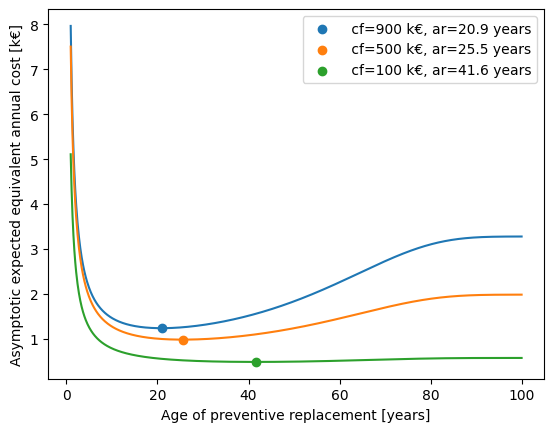

In [11]:
range_ar = np.arange(1, 100, 0.1)
range_asymptotic_EEAC = AgeReplacementPolicy(
    gompertz, cf, cp, discount_rate=discount_rate, a0=a0, ar=range_ar, ar1=ar1
).asymptotic_expected_equivalent_annual_cost()

for asset_i in range(ar.shape[0]):
    plt.plot(range_ar, range_asymptotic_EEAC[asset_i])
    plt.scatter(
        ar[asset_i],
        min_asymptotic_EEAC[asset_i],
        c=f"C{asset_i}",
        label=f" cf={cf[asset_i,0]} k€, ar={ar[asset_i][0]:0.1f} years",
    )
plt.xlabel("Age of preventive replacement [years]")
plt.ylabel("Asymptotic expected equivalent annual cost [k€]")
plt.legend()
plt.show()

## Budget and operations planning

For budgeting, the expected total discounted costs for the 3 circuit breakers are computed and we can plot the total annual discounted costs for the next 30 years, including costs of failures and costs of preventive replacements.

Then the total number of replacements are projected for the next 30 years. Failure replacements are counted separately in order to prevent and prepare the workload of the maintenance teams.

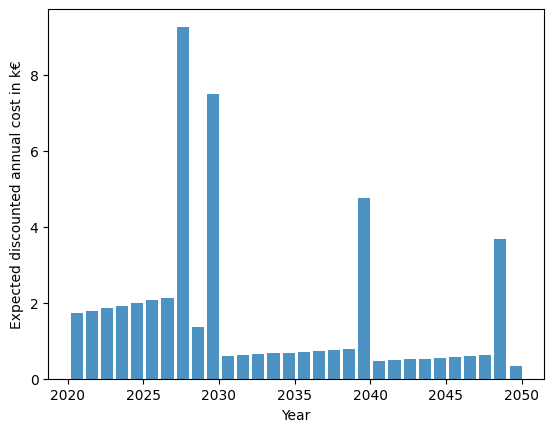

In [12]:
dt = 0.5
step = int(1 / dt)
timeline = np.arange(0, 30 + dt, dt)
z = policy.expected_total_cost(timeline).sum(axis=0)
y = timeline[::step][1:]
q = np.diff(z[::step])
plt.bar(2020 + y, q, align="edge", width=-0.8, alpha=0.8)
plt.xlabel("Year")
plt.ylabel("Expected discounted annual cost in k€")
plt.show()

The figure shows the expected replacements for the very small sample of 3 circuit breakers. When the population of assets is large, the expected failure replacements is a useful information to build up a stock of materials.

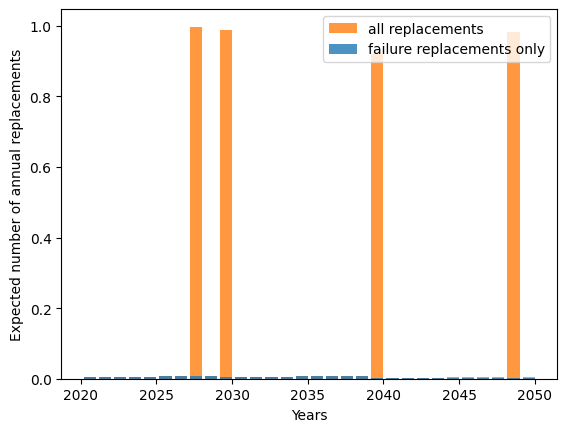

In [13]:
mt = (
    AgeReplacementPolicy(gompertz, cf=1, cp=1, discount_rate=0, ar=ar, ar1=ar1, a0=a0)
    .expected_total_cost(timeline)
    .sum(axis=0)
)
mf = (
    AgeReplacementPolicy(gompertz, cf=1, cp=0, discount_rate=0, ar=ar, ar1=ar1, a0=a0)
    .expected_total_cost(timeline)
    .sum(axis=0)
)
qt = np.diff(mt[::step])
qf = np.diff(mf[::step])
plt.bar(
    y + 2020,
    qt,
    align="edge",
    width=-0.8,
    alpha=0.8,
    color="C1",
    label="all replacements",
)
plt.bar(
    y + 2020,
    qf,
    align="edge",
    width=-0.8,
    alpha=0.8,
    color="C0",
    label="failure replacements only",
)
plt.xlabel("Years")
plt.ylabel("Expected number of annual replacements")
plt.legend()
plt.show()